In [9]:
import torch
torch.cuda.empty_cache()

In [10]:
# 필요한 라이브러리 임포트
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys
import random
from sklearn.model_selection import KFold

# 다시 임포트
from models_jh import CNN
from Segdataset_jh import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

In [11]:
print(CNN)

<class 'models_jh.CNN'>


In [12]:
class Args:
    def __init__(self):
        self.data_root = '/workspace/dataset/CREMA-D/train'
        self.save_root = '/workspace/UndergraduateResearchAssistant/GraduateProject/code/CREMA-D/checkpoints_jh'
        self.epoch = 400
        self.lr = 1e-5
        self.batch_size = 64
        self.num_workers = 16
        self.random_seed = 1
        self.n_mfcc = 20
        self.n_splits = 5

opt = Args()


In [13]:
def main():
    print("Training by CNN")

    # 저장 디렉토리 없으면 생성
    if not os.path.exists(opt.save_root):
        os.makedirs(opt.save_root)
        print('Created directory:', opt.save_root)

    # 데이터셋 로딩
    mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)

    # KFold cross-validation
    kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    all_train_epoch_loss = []
    all_test_epoch_loss = []
    all_test_epoch_accuracy_emotion = []

    return kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [14]:
def train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion):
    for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
        print(f"Fold {fold + 1}/{opt.n_splits}")

        # 모델을 fold마다 초기화
        model = CNN().to(device)

        # 학습/검증 데이터로 쪼개기
        train_mfcc = [mfcc_list[i] for i in train_idx]
        train_emotion = [emotion_list[i] for i in train_idx]
        val_mfcc = [mfcc_list[i] for i in val_idx]
        val_emotion = [emotion_list[i] for i in val_idx]

        train_set = SegDataset(train_mfcc, train_emotion)
        val_set = SegDataset(val_mfcc, val_emotion)

        # Create dataloaders
        train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
        val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

        # 각 fold에 따라 pos_weight 동적으로 설정
        num_pos = sum(em == 1 for em in train_emotion)
        num_neg = sum(em == 0 for em in train_emotion)
        pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

        # loss and optimizer 선언
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        optimizer = optim.Adam(model.parameters(), lr=opt.lr)

        # 현재 폴드 값들 저장
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float('inf')
        best_epoch = 0

        for epo in range(opt.epoch):
            model.train()
            train_loss = 0

            for index, (mfcc, emotion) in enumerate(train_loader):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                optimizer.zero_grad()
                output_emotion = model(mfcc)

                emotion = emotion.float()
                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증
            model.eval()
            val_loss = 0
            correct_emotion = 0
            total = 0
            with torch.no_grad():
                for mfcc, emotion in val_loader:
                    mfcc, emotion = mfcc.to(device), emotion.to(device)
                    output_emotion = model(mfcc)
                    emotion = emotion.float()

                    loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                    val_loss += loss.item()

                    predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.5).float()
                    correct_emotion += (predicted_emotion == emotion).sum().item()
                    total += emotion.size(0)

            val_accuracy = correct_emotion / total
            print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

            # 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epo
                torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))

            # Track the training and validation losses and accuracies for plotting later
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        print(f"Fold{fold+1} best epoch : {best_epoch} ")

        all_train_epoch_loss.append(train_losses)
        all_test_epoch_loss.append(val_losses)
        all_test_epoch_accuracy_emotion.append(val_accuracies)

        plot_fold_performance(train_losses, val_losses, val_accuracies, fold)

    return all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [15]:
def plot_fold_performance(train_losses, val_losses, val_accuracies, fold):
    # Fold별로 그래프를 그리기 (Colab에서 바로 확인 가능하도록)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Training by CNN
Using device: cuda
Fold 1/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 1 | Epoch 0 | Train Loss: 0.43509636859636047 | Val Loss: 0.4313846114608977 | Val Accuracy: 0.6050347222222222
Fold 1 | Epoch 1 | Train Loss: 0.4307242358053053 | Val Loss: 0.42697997556792366 | Val Accuracy: 0.6197916666666666
Fold 1 | Epoch 2 | Train Loss: 0.4266804251316431 | Val Loss: 0.423093244433403 | Val Accuracy: 0.6163194444444444
Fold 1 | Epoch 3 | Train Loss: 0.42307539646689957 | Val Loss: 0.41896135442786747 | Val Accuracy: 0.6241319444444444
Fold 1 | Epoch 4 | Train Loss: 0.4189204561549264 | Val Loss: 0.41494788395033944 | Val Accuracy: 0.6267361111111112
Fold 1 | Epoch 5 | Train Loss: 0.4153914153575897 | Val Loss: 0.41059835917419857 | Val Accuracy: 0.6371527777777778
Fold 1 | Epoch 6 | Train Loss: 0.41130250047993017 | Val Loss: 0.40670691927274066 | Val Accuracy: 0.6388888888888888
Fold 1 | Epoch 7 | Train Loss: 0.40754400999159424 | Val Loss: 0.4031

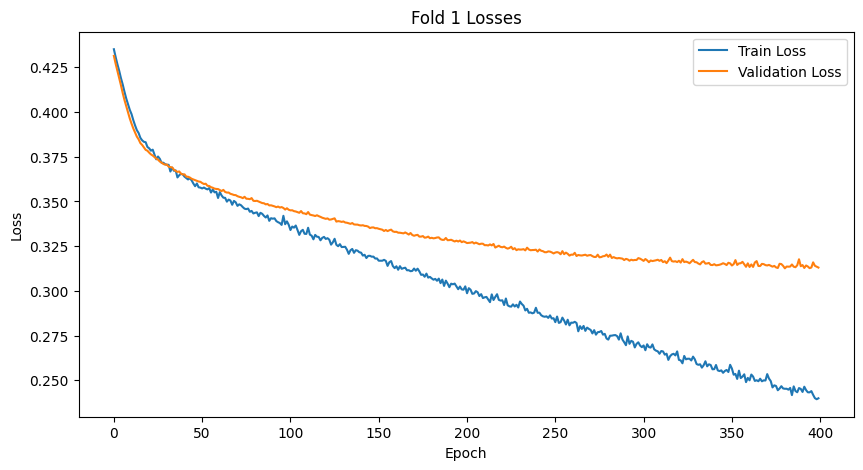

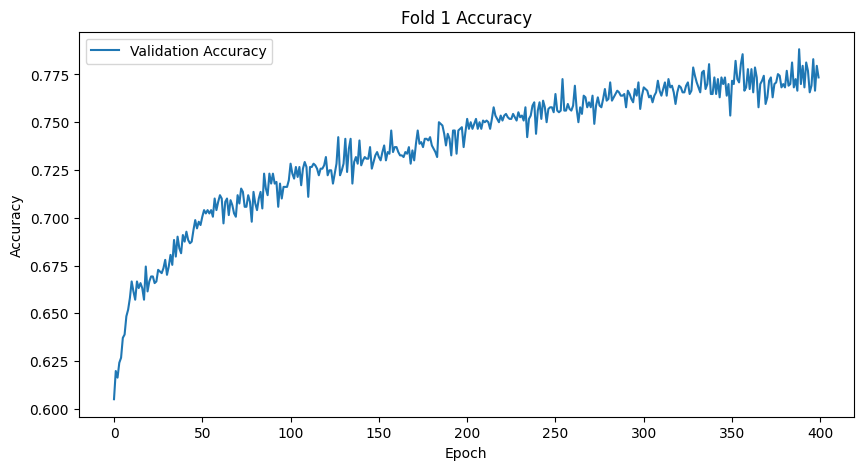

Fold 2/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 2 | Epoch 0 | Train Loss: 0.43996883767682154 | Val Loss: 0.4393485552734799 | Val Accuracy: 0.5538194444444444
Fold 2 | Epoch 1 | Train Loss: 0.4347319055247951 | Val Loss: 0.4327391783396403 | Val Accuracy: 0.6223958333333334
Fold 2 | Epoch 2 | Train Loss: 0.43017590730576905 | Val Loss: 0.4271255185206731 | Val Accuracy: 0.6284722222222222
Fold 2 | Epoch 3 | Train Loss: 0.42577112365413355 | Val Loss: 0.42206769850518966 | Val Accuracy: 0.6414930555555556
Fold 2 | Epoch 4 | Train Loss: 0.4222575144187824 | Val Loss: 0.41770508885383606 | Val Accuracy: 0.6345486111111112
Fold 2 | Epoch 5 | Train Loss: 0.4189890389506881 | Val Loss: 0.41347328656249577 | Val Accuracy: 0.6293402777777778
Fold 2 | Epoch 6 | Train Loss: 0.415528174187686 | Val Loss: 0.4093851430548562 | Val Accuracy: 0.6449652777777778
Fold 2 | Epoch 7 | Train Loss: 0.4123994397955972 | Val Loss: 0.40593874123361373 | Val Accuracy: 0.658854

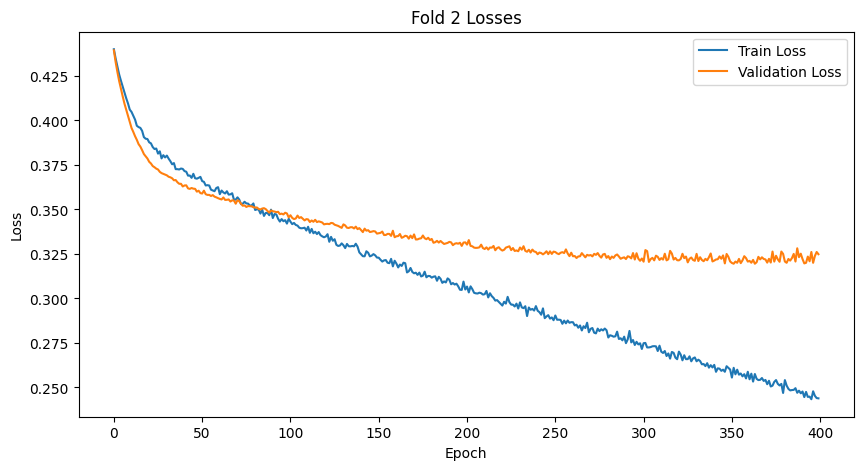

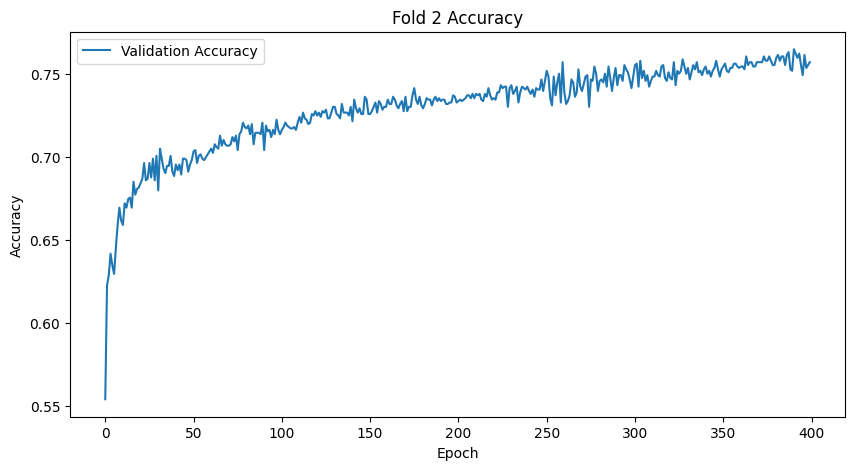

Fold 3/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 3 | Epoch 0 | Train Loss: 0.4394552421730918 | Val Loss: 0.4407215399874581 | Val Accuracy: 0.6145833333333334
Fold 3 | Epoch 1 | Train Loss: 0.4315786152272611 | Val Loss: 0.4337341984113057 | Val Accuracy: 0.6571180555555556
Fold 3 | Epoch 2 | Train Loss: 0.426602579049162 | Val Loss: 0.42778171930048203 | Val Accuracy: 0.6493055555555556
Fold 3 | Epoch 3 | Train Loss: 0.4216231309078835 | Val Loss: 0.42330309251944226 | Val Accuracy: 0.6475694444444444
Fold 3 | Epoch 4 | Train Loss: 0.4168677591794246 | Val Loss: 0.41879690024587846 | Val Accuracy: 0.6449652777777778
Fold 3 | Epoch 5 | Train Loss: 0.4127581759884551 | Val Loss: 0.41419559551609886 | Val Accuracy: 0.6380208333333334
Fold 3 | Epoch 6 | Train Loss: 0.40893379417625636 | Val Loss: 0.41041626698440975 | Val Accuracy: 0.6397569444444444
Fold 3 | Epoch 7 | Train Loss: 0.4053377416488287 | Val Loss: 0.4072539723581738 | Val Accuracy: 0.6614583

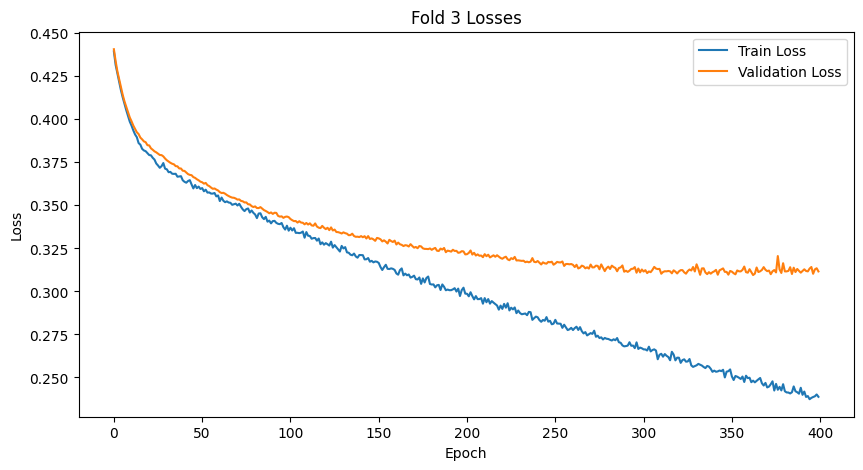

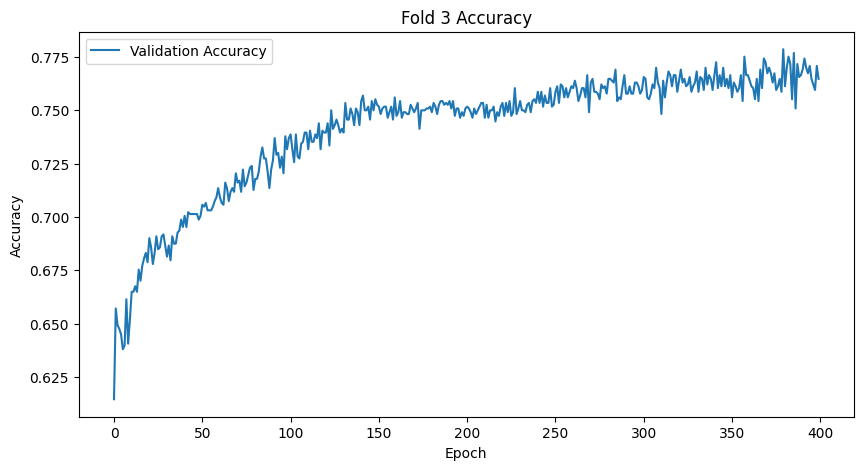

Fold 4/5
Dataset loaded with 4763 samples.
Dataset loaded with 1190 samples.
Fold 4 | Epoch 0 | Train Loss: 0.4350204560402277 | Val Loss: 0.4329303552707036 | Val Accuracy: 0.6215277777777778
Fold 4 | Epoch 1 | Train Loss: 0.4294739232675449 | Val Loss: 0.4280084702703688 | Val Accuracy: 0.6050347222222222
Fold 4 | Epoch 2 | Train Loss: 0.42496918584849386 | Val Loss: 0.42368293305238086 | Val Accuracy: 0.5763888888888888
Fold 4 | Epoch 3 | Train Loss: 0.4199439577154211 | Val Loss: 0.41952313317192924 | Val Accuracy: 0.6085069444444444
Fold 4 | Epoch 4 | Train Loss: 0.4162547459473481 | Val Loss: 0.4160553581184811 | Val Accuracy: 0.6397569444444444
Fold 4 | Epoch 5 | Train Loss: 0.4120166531285724 | Val Loss: 0.4128393332163493 | Val Accuracy: 0.6328125
Fold 4 | Epoch 6 | Train Loss: 0.40798755916389257 | Val Loss: 0.409866601228714 | Val Accuracy: 0.6397569444444444
Fold 4 | Epoch 7 | Train Loss: 0.4057198464870453 | Val Loss: 0.40721434851487476 | Val Accuracy: 0.6354166666666666


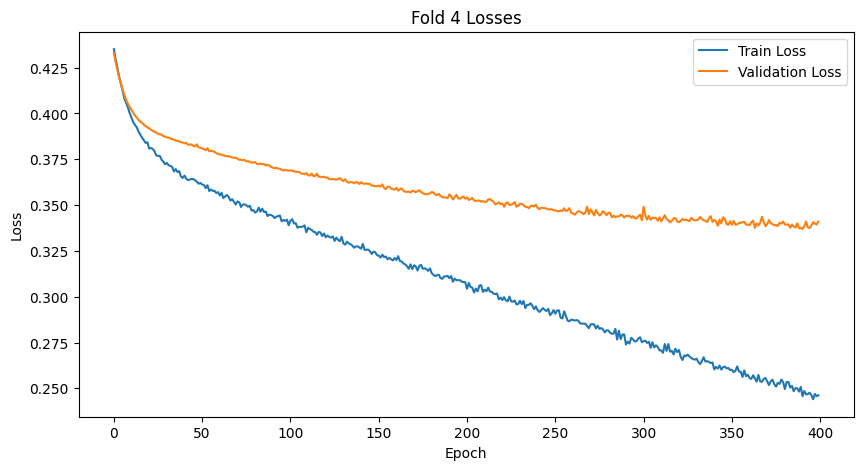

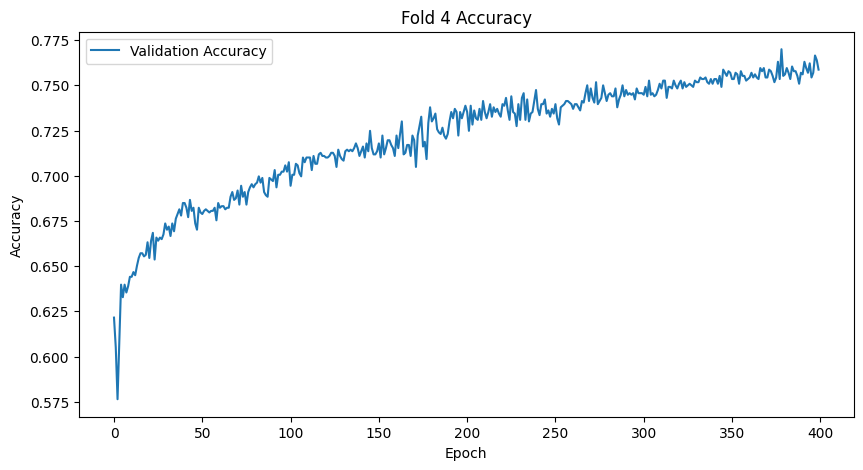

Fold 5/5
Dataset loaded with 4763 samples.
Dataset loaded with 1190 samples.
Fold 5 | Epoch 0 | Train Loss: 0.43959355152942037 | Val Loss: 0.4363395869731903 | Val Accuracy: 0.4982638888888889
Fold 5 | Epoch 1 | Train Loss: 0.4348551159774935 | Val Loss: 0.43243905405203503 | Val Accuracy: 0.5286458333333334
Fold 5 | Epoch 2 | Train Loss: 0.43072014442972234 | Val Loss: 0.42875417239136165 | Val Accuracy: 0.5321180555555556
Fold 5 | Epoch 3 | Train Loss: 0.42678260239394933 | Val Loss: 0.42527463535467785 | Val Accuracy: 0.5677083333333334
Fold 5 | Epoch 4 | Train Loss: 0.4221165204370344 | Val Loss: 0.42123300830523175 | Val Accuracy: 0.5894097222222222
Fold 5 | Epoch 5 | Train Loss: 0.4188581644683271 | Val Loss: 0.4179730365673701 | Val Accuracy: 0.6223958333333334
Fold 5 | Epoch 6 | Train Loss: 0.41555253678076975 | Val Loss: 0.4143741594420539 | Val Accuracy: 0.6241319444444444
Fold 5 | Epoch 7 | Train Loss: 0.41103001905454173 | Val Loss: 0.41167782578203416 | Val Accuracy: 0.62

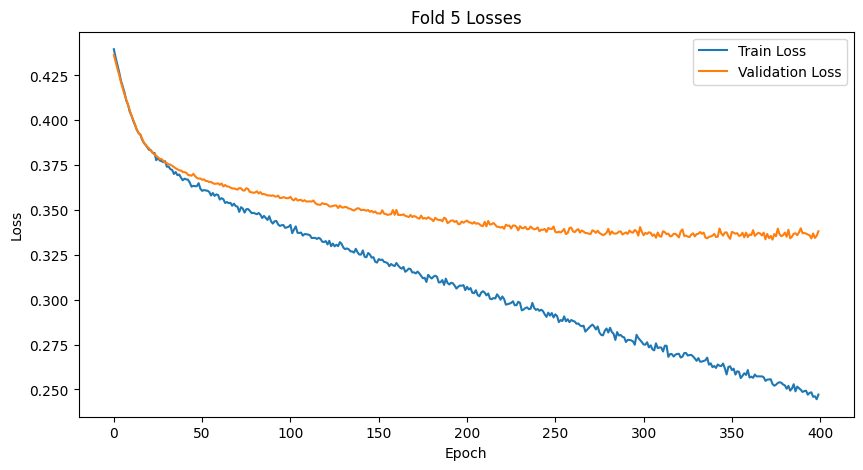

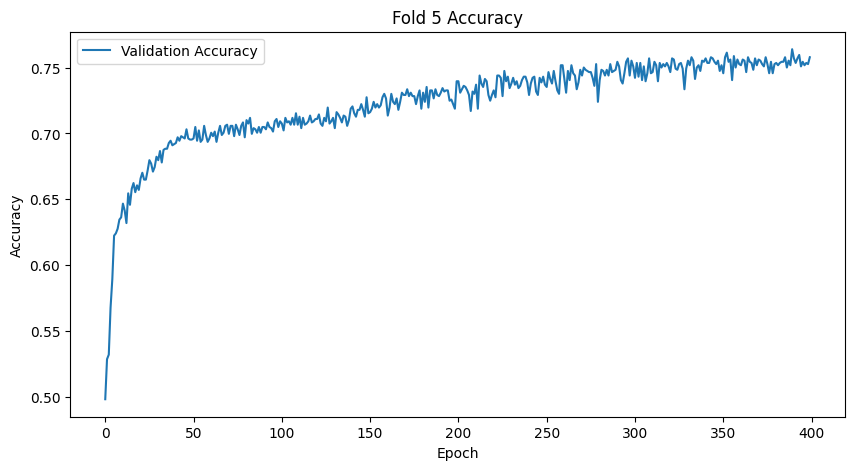

In [16]:
if __name__ == '__main__':
    kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion = main()
    train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion)